<a href="https://colab.research.google.com/github/mgarciasanes/metodosdeagrupamiento_nosupervisado/blob/master/01_particiones_kmeanspp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> Aplicación de los Métodos de Agrupamiento</h1></center>
<center><h1> Aprendizaje No Supervisado</h1></center>
<center><h1> Agrupamiento por pareticiones : K-means++</h1></center>
<br>

### - Alexandro López González
### - Leonardo Pacheco Garduño
### - Manuel Garcia Sanes
<br>
<br>

En este notebook, realizaremos los siguiente:

- Aplicación del algoritmo K-means ++  a los dos datasets seleccionados. 

- Evaluación de los resultados utilizando métricas intrínsecas o extrínsecas según sea el caso

- Análisis del resultado
<br>
<br>


---
## 1. Cargamos las librerias necesarias   

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


## 2. Cargamos el dataset con agrupamiento conocido   

####Nombre:

SEEDS



####Abstract: <br>

Measurements of geometrical properties of kernels belonging to three different varieties of wheat. A soft X-ray technique and GRAINS package were used to construct all seven, real-valued attributes.
	
####Atributos (Reales): <br>
1. area A,
2. perimeter P,
3. compactness C = 4*pi*A/P^2,
4. length of kernel,
5. width of kernel,
6. asymmetry coefficient
7. length of kernel groove.
All of these parameters were real-valued continuous.

####Instancias: 
210

####URL: 
https://archive.ics.uci.edu/ml/datasets/seeds# <br>


El dataset cargado tiene 210 instancias, 7 atributos y 3 clusters.


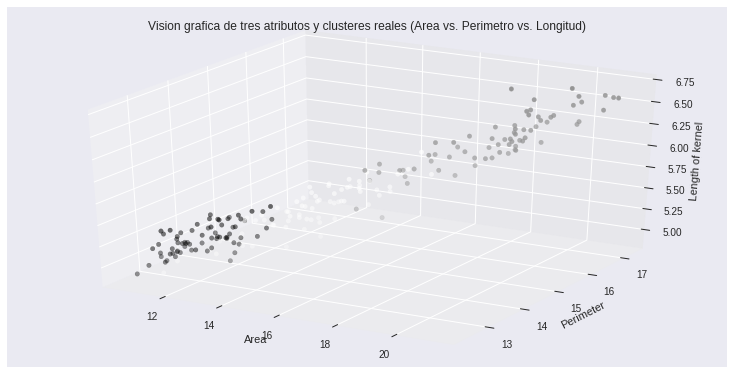

In [0]:
np.random.seed(31) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

#Cargamos los datos
data_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'

#Mezclamos y separamos la columa clase  
D = np.array(pd.read_csv(data_file_url,delimiter='\s+', header=None))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:-1]
Dy = D[:,-1]

#Mostrar graficamente los datos (solo 3 atributos)
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3], c=Dy)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica de tres atributos y clusteres reales (Area vs. Perimetro vs. Longitud)")


print('El dataset cargado tiene',Dx.shape[0],'instancias,', Dx.shape[1], 'atributos y' ,len(np.unique(Dy)) , 'clusters.')

## 2.1 Aplicamos el Algoritmo seleccinado: K-means ++


El algoritmo K-means tiene un único parámetro: el número de clústeres (K). Una vez fijado este valor, el primer paso consiste en elegir unos centros iniciales.

Hemos querido incluir la representacion grafica de los datos. Aunque los datos tienen 7 atributos, representamos solo 3 de ellos:



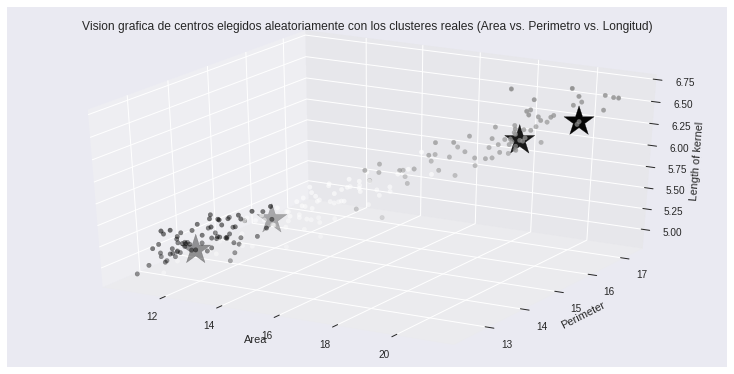

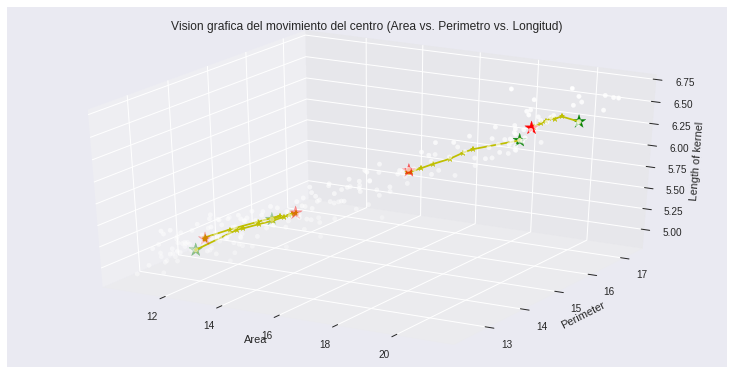

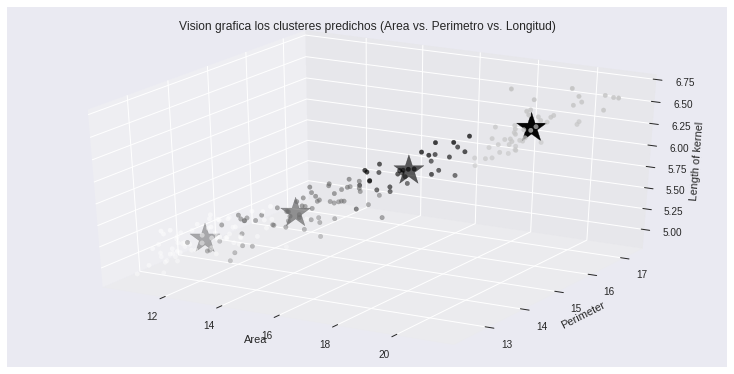

In [0]:
# Elegimos un número de clústeres a buscar (Sabemos que son 4)
K = 4


# Definimos las distancia euclidiana minima de una instancia x
# con respecto a un grupo de instancias c
def min_distancia_euclidiana_grupo(x, C):
    return np.min(np.sqrt(np.sum(np.power(C-x,2),axis=1)))

# Definimos la distancia euclidiana de una instancia x 
# con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):   
    return np.sqrt(np.sum(np.power(C-x,2),axis=1))
  
  
    
# Preparamos un arreglo para los centros   
cDx = np.zeros(Dx.shape[1])
cDx.shape = (1,Dx.shape[1])


icenter = np.random.randint(Dx.shape[0])
cDx[0,:] = Dx[icenter,:]
auxDx = np.delete(Dx, icenter, 0)


for k in np.arange(K-1):
    dist_min = np.zeros(auxDx.shape[0])
    for i in np.arange(auxDx.shape[0]):
        dist_min[i] = min_distancia_euclidiana_grupo(auxDx[i,:], cDx)
    probs = np.square(dist_min)/np.sum(np.square(dist_min))
    cumprobs = np.cumsum(probs)
    icenter = np.where(cumprobs >= np.random.random_sample())[0][0]
    cDx= np.append(cDx, np.matrix(auxDx[icenter,:]), axis=0)
    auxDx = np.delete(auxDx, icenter, 0)

#print('Los centros iniciales elegidos aleatoriamente son:')
#print(cDx)


fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3], c=Dy)
ax.scatter(cDx[:, 0], cDx[:, 1], cDx[:, 3], marker='*', c='#050505', s=1000)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica de centros elegidos aleatoriamente con los clusteres reales (Area vs. Perimetro vs. Longitud)")



# Preparamos el vector donde guardamos la asignación de cada elemento 
# a un clúster (1,...,K)
Dyp = np.zeros(Dx.shape[0])

# Preparamos la representacion grafica del progreso de seleccion de los centros
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3], c=Dyp)
ax.scatter(cDx[:, 0], cDx[:, 1], cDx[:, 3], marker='*', c='g', s=200)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica del movimiento del centro (Area vs. Perimetro vs. Longitud)")



# Flag de convergencia
iterando = True

# Iniciamos la iteracion...
while iterando:

    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()

    # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
    for i in np.arange(Dx.shape[0]):
        pred_y = np.argmin(distancia_euclidiana_grupo(Dx[i],cDx))
        Dyp[i] = pred_y

    # Calcular los nuevos centros
    for k in range(K):
        cDx[k,:] = Dx[Dyp==k].mean(axis=0)

    # Anadirlo a la grafica
    for k in np.arange(K):
        ax.plot( [cDx_ant[k,0], cDx[k,0]],[cDx_ant[k,1], cDx[k,1]],[cDx_ant[k,3], cDx[k,3]], linestyle='-', marker='*', c='y')
        
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)

    
# Anadimos los centros finales a la grafica con diferente color     
ax.scatter(np.array(cDx[:,0]),np.array(cDx[:,1]),np.array(cDx[:,3]) ,marker='*', s=200, c='r')


# Ver asignaciones finales
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3], c=Dyp)
ax.scatter(cDx[:, 0], cDx[:, 1], cDx[:, 3], marker='*', c='#050505', s=1000)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica los clusteres predichos (Area vs. Perimetro vs. Longitud)")
print("Hemos querido incluir la representacion grafica de los datos. Aunque los datos tienen 7 atributos, representamos solo 3 de ellos:")
print()

## 2.2 Evaluacion Extriniseca del Algoritmo seleccinado: K-means ++

1.   List item
2.   List item






In [0]:
#Evaluacion aqui

## 2.3 Analisis de la evlauciaon del Algoritmo seleccinado: K-means ++


### ANALISIS AQUI


## 3. Cargamos el dataset con agrupamiento desconocido   

####Nombre:

ONLINE SHOPERS PURCHASING INTENTIONS



####Abstract: <br>

Of the 12,330 sessions in the dataset, 84.5% (10,422) were negative class samples that did not end with shopping, and the rest (1908) were positive class samples ending with shopping.
	.
	
	
####Atributos : <br>
1. Administrative
2. Administrative Duration
3. Informational
4. Informational Duration
5. Product Related
6. Product Related Duration 
7. Bounce Rate
8. Exit Rate
9. Page Value
10. Special Day 
11. month of the year
12. operating system
13. browser
14. region
15. traffic type
16. visitor type 
17. weekend
18. revenue


####Instancias: 
12330

####URL: 
https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset# <br>


El dataset cargado tiene 12330 instancias y  18  atributos


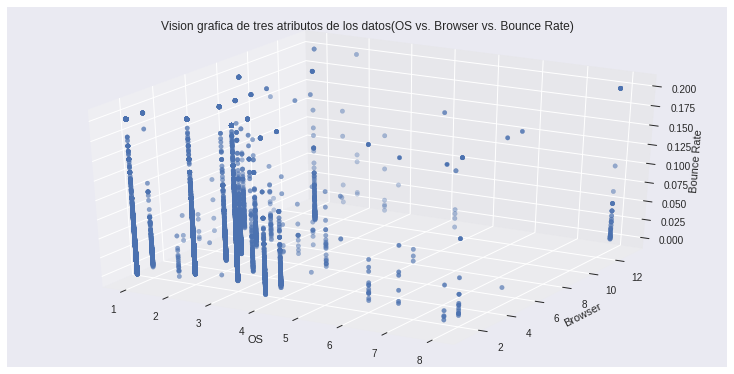

In [17]:
np.random.seed(31) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

#Cargamos los datos
data_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv'

#Mezclamos   
D = np.array(pd.read_csv(data_file_url, header=0))
Dx = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]




# Mapear valores de texto a numeros. Columna 10 (month). Jan=1, Feb=2,...
for month,num in zip(['Jan', 'Feb', 'Mar' , 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],range(12)):
    Dx[Dx[:,10]==month,10]=num

# Mapear valores de texto a numeros. Columna 15 (Vistor_type). New_Visitor=1, Returning_Visitor=2,Other=3
Dx[Dx[:,15]=='New_Visitor',15]=1
Dx[Dx[:,15]=='Returning_Visitor',15]=2
Dx[Dx[:,15]=='Other',15]=3


# Mapear valores de texto a numeros. Columna 16 (wekend). 
for valor,num in zip([False, True],range(2)):
    Dx[Dx[:,16]==valor,16]=num

# Mapear valores de texto a numeros. Columna 17 (revenuw). 
for valor,num in zip([False, True],range(2)):
    Dx[Dx[:,17]==valor,17]=num
    
    


#Mostrar graficamente los datos (solo 3 atributos)
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 11], Dx[:, 12], Dx[:, 7])
ax.set_xlabel("OS")
ax.set_ylabel("Browser")
ax.set_zlabel("Bounce Rate")
ax.set_title("Vision grafica de tres atributos de los datos(OS vs. Browser vs. Bounce Rate)")




print('El dataset cargado tiene',Dx.shape[0],'instancias y ', Dx.shape[1], ' atributos')

## 3.1 Aplicamos el Algoritmo seleccinado: K-means ++


El algoritmo K-means tiene un único parámetro: el número de clústeres (K). 


## 3.1.1 Eleccion de K (Regla del Codo)

Text(0, 0.5, 'Medida de R cuadrado')

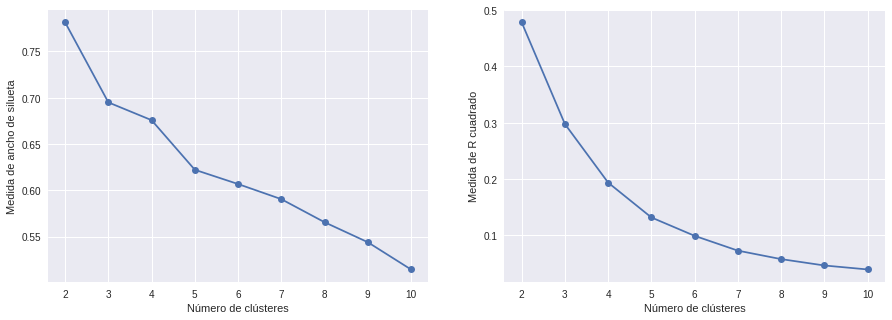

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def medida_R_cuadrado(X, Xyp, cXs):
    cXglob = np.mean(X,axis=0) 
    labels = np.sort(np.unique(Xyp))
    sumTotal = np.sum(np.sum(X-cXglob,1)**2) 
    interior = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
    
    return interior/sumTotal 

rsilueta = np.zeros(9)
rrsquare = np.zeros(9)
for k in np.arange(2,11):
    modelo = KMeans(n_clusters=k)
    modelo = modelo.fit(Dx)
    Dyp_sk = modelo.predict(Dx)
    cDx_sk = modelo.cluster_centers_
    rsilueta[k-2] = silhouette_score(Dx, Dyp_sk)
    rrsquare[k-2]  = medida_R_cuadrado(Dx, Dyp_sk, cDx_sk)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rsilueta, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de ancho de silueta")

ax[1].plot( np.arange(2,11),rrsquare, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Medida de R cuadrado")






## 3.1.2 Buscando Centroides ( K = 3 )

In [18]:
# Elegimos un número de clústeres a buscar (Sabemos que son 4)
K = 3
      
# Preparamos un arreglo para los centros   
cDx = np.zeros(Dx.shape[1])
cDx.shape = (1,Dx.shape[1])

icenter = np.random.randint(Dx.shape[0])
cDx[0,:] = Dx[icenter,:]
auxDx = np.delete(Dx, icenter, 0)
auxDx=auxDx.astype('float64')


for k in np.arange(K-1):
    dist_min = np.zeros(auxDx.shape[0])
    for i in np.arange(auxDx.shape[0]):
        dist_min[i] = min_distancia_euclidiana_grupo(auxDx[i,:], cDx)
    probs = np.square(dist_min)/np.sum(np.square(dist_min))
    cumprobs = np.cumsum(probs)
    icenter = np.where(cumprobs >= np.random.random_sample())[0][0]
    cDx= np.append(cDx, np.matrix(auxDx[icenter,:]), axis=0)
    auxDx = np.delete(auxDx, icenter, 0)

print('Los centros iniciales elegidos aleatoriamente son:')
print(cDx)


Los centros iniciales elegidos aleatoriamente son:
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.00000000e+00 6.24000000e+01 0.00000000e+00 6.66666670e-02
  0.00000000e+00 0.00000000e+00 5.00000000e+00 2.00000000e+00
  2.00000000e+00 3.00000000e+00 3.00000000e+00 2.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.50000000e+01 9.56333333e+02 1.33333330e-02 4.66666670e-02
  2.01390762e+01 0.00000000e+00 1.00000000e+01 2.00000000e+00
  2.00000000e+00 3.00000000e+00 1.00000000e+00 2.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.00000000e+00 1.47175000e+02 7.00000000e+00 2.54000000e+02
  3.40000000e+02 1.09024583e+04 1.71320700e-03 1.57349570e-02
  0.00000000e+00 0.00000000e+00 1.00000000e+01 2.00000000e+00
  2.00000000e+00 1.00000000e+00 2.00000000e+00 2.00000000e+00
  0.00000000e+00 0.00000000e+00]]



## 3.1.3 Aplicando Algoritmo 


Hemos querido incluir la representacion grafica de los datos. Aunque los datos tienen 7 atributos, representamos solo 3 de ellos:



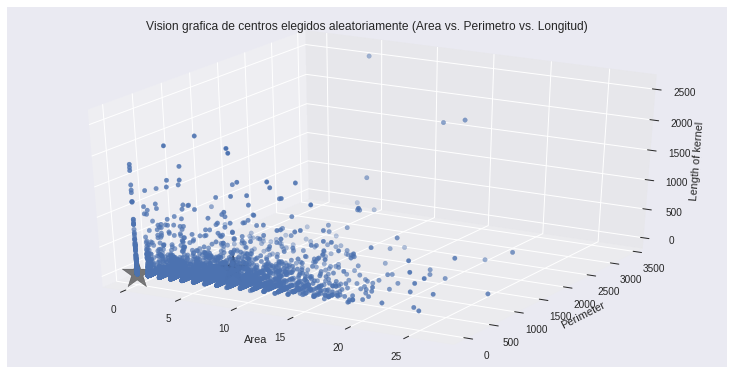

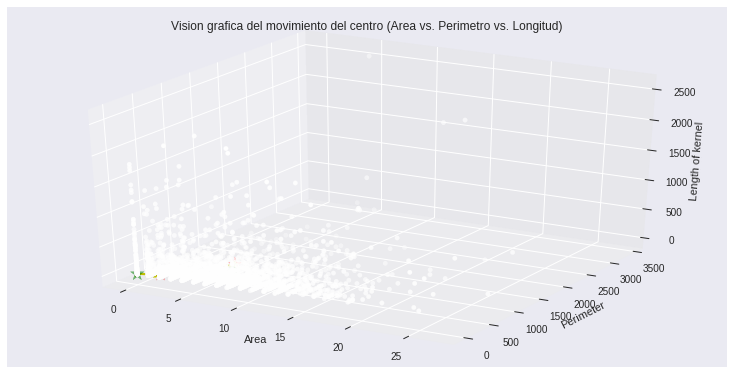

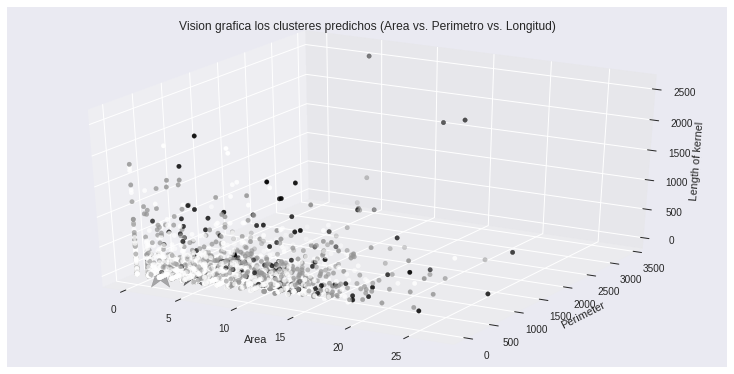

In [19]:
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3])
ax.scatter(cDx[:, 0], cDx[:, 1], cDx[:, 3], marker='*', c='#050505', s=1000)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica de centros elegidos aleatoriamente (Area vs. Perimetro vs. Longitud)")



# Preparamos el vector donde guardamos la asignación de cada elemento 
# a un clúster (1,...,K)
Dyp = np.zeros(Dx.shape[0])

# Preparamos la representacion grafica del progreso de seleccion de los centros
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3], c=Dyp)
ax.scatter(cDx[:, 0], cDx[:, 1], cDx[:, 3], marker='*', c='g', s=200)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica del movimiento del centro (Area vs. Perimetro vs. Longitud)")



Dx=Dx.astype('float64')

# Flag de convergencia
iterando = True

# Iniciamos la iteracion...
while iterando:

    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()

    # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
    for i in np.arange(Dx.shape[0]):
        pred_y = np.argmin(distancia_euclidiana_grupo(Dx[i],cDx))
        Dyp[i] = pred_y

    # Calcular los nuevos centros
    for k in range(K):
        cDx[k,:] = Dx[Dyp==k].mean(axis=0)

    # Anadirlo a la grafica
    for k in np.arange(K):
        ax.plot( [cDx_ant[k,0], cDx[k,0]],[cDx_ant[k,1], cDx[k,1]],[cDx_ant[k,3], cDx[k,3]], linestyle='-', marker='*', c='y')
        
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)

    
# Anadimos los centros finales a la grafica con diferente color     
ax.scatter(np.array(cDx[:,0]),np.array(cDx[:,1]),np.array(cDx[:,3]) ,marker='*', s=200, c='r')


# Ver asignaciones finales
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
ax.scatter(Dx[:, 0], Dx[:, 1], Dx[:, 3], c=Dyp)
ax.scatter(cDx[:, 0], cDx[:, 1], cDx[:, 3], marker='*', c='#050505', s=1000)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_zlabel("Length of kernel")
ax.set_title("Vision grafica los clusteres predichos (Area vs. Perimetro vs. Longitud)")
print("Hemos querido incluir la representacion grafica de los datos. Aunque los datos tienen 7 atributos, representamos solo 3 de ellos:")
print()

## 3.2 Evaluacion Intrinseca del Algoritmo seleccinado: K-means ++

1.   List item
2.   List item



## 3.3 Analisis de la evlauciaon del Algoritmo seleccinado: K-means ++


### ANALISIS AQUI